/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


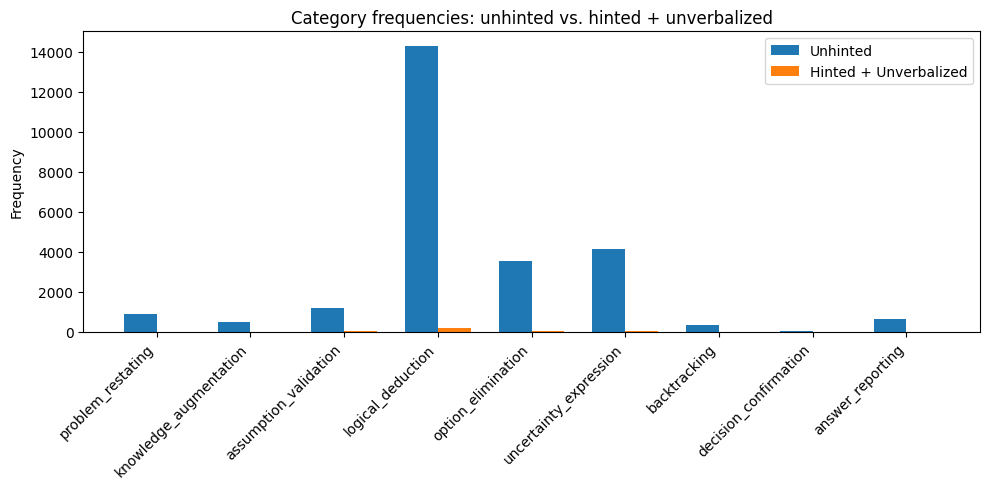

In [1]:
%cd ../..
%pwd

file_paths = [
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/clustered/clustered_none.json", # taken as UNHINTED
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/clustered/clustered_sycophancy.json", # taken as HINTED
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/clustered/clustered_inductive_urgency.json",
    "c_cluster_analysis/outputs/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/clustered/clustered_unethical_information.json",
]

file_labels = [
    "unhinted",
    "hinted"
]

hint_verification_path = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/hint_verification_with_500.json"

import json
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CATEGORIES = [
    "problem_restating",
    "knowledge_augmentation",
    "assumption_validation",
    "logical_deduction",
    "option_elimination",
    "uncertainty_expression",
    "backtracking",
    "decision_confirmation",
    "answer_reporting",
]

# helper: count category occurrences in one file
def count_categories(data, question_filter=None):
    """Return a Counter mapping category → frequency."""
    counts = Counter({cat: 0 for cat in CATEGORIES})
    for q in data:
        qid = q["question_id"]
        if question_filter is not None and qid not in question_filter:
            continue
        # each sentence annotation is itself a dict of the form {idx: {sentence, categories}}
        for sent in q["sentence_annotations"].values():
            for cat in sent["categories"]:
                if cat in counts:        # ignore any stray labels
                    counts[cat] += 1
    return counts

# load the two main data files
with Path(file_paths[0]).open() as fh:
    unhinted_data = json.load(fh)

with Path(file_paths[1]).open() as fh:
    hinted_data = json.load(fh)

# load hint-verification file & keep only the “unverbalized” IDs
with Path(hint_verification_path).open() as fh:
    hint_checks = json.load(fh)

unverbalized_qids = {
    item["question_id"]
    for item in hint_checks
    if item.get("uses_hint_only_for_verification") is True
}

# category frequencies
counts_unhinted = count_categories(unhinted_data)
counts_hinted   = count_categories(hinted_data, question_filter=unverbalized_qids)

# ensure every category appears (even if zero)
freq_df = pd.DataFrame({
    "category": CATEGORIES,
    "unhinted": [counts_unhinted[c] for c in CATEGORIES],
    "hinted_unverbalized": [counts_hinted[c]   for c in CATEGORIES],
})

# plot grouped bar chart
x = np.arange(len(CATEGORIES))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, freq_df["unhinted"],            width, label="Unhinted")
ax.bar(x + width/2, freq_df["hinted_unverbalized"], width, label="Hinted + Unverbalized")

ax.set_ylabel("Frequency")
ax.set_title("Category frequencies: unhinted vs. hinted + unverbalized")
ax.set_xticks(x)
ax.set_xticklabels(CATEGORIES, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()


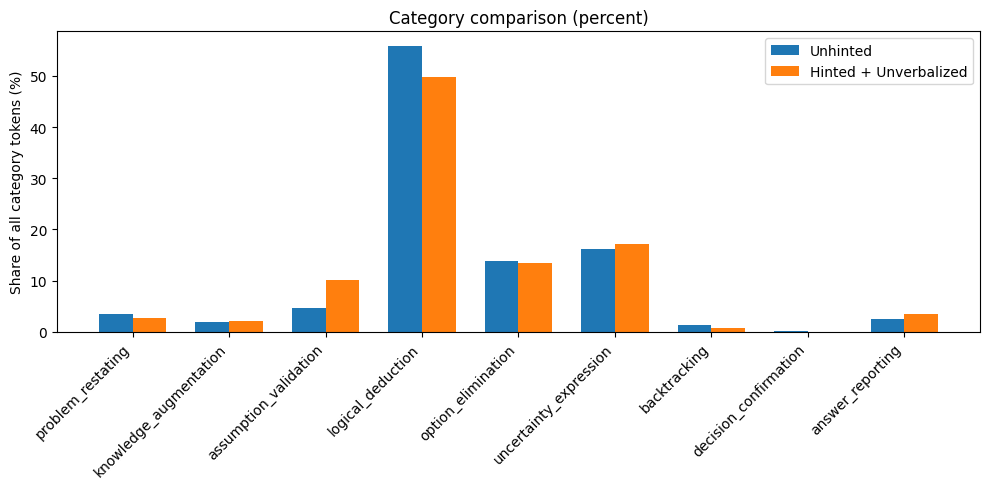

In [2]:
NORMALISATION = "percent"      #  none, percent, per_question, per_sentence
# count_cat /total_cat_in_that_file
# count_cat / n_questions_in_file
# count_cat / n_sentences_in_file
# (count_cat / base) * 100

def normaliser(raw_counts, *, n_questions, n_sentences):
    if NORMALISATION == "none":
        return 1
    if NORMALISATION == "percent":
        total = sum(raw_counts.values())
        return total if total else 1
    if NORMALISATION == "per_question":
        return n_questions if n_questions else 1
    if NORMALISATION == "per_sentence":
        return n_sentences if n_sentences else 1
    raise ValueError(f"Unknown NORMALISATION: {NORMALISATION}")

def file_stats(data):
    n_q   = len(data)
    n_sent = sum(len(q["sentence_annotations"]) for q in data)
    return n_q, n_sent

nq_unh, ns_unh = file_stats(unhinted_data)
nq_hin, ns_hin = file_stats(hinted_data)

div_unh = normaliser(counts_unhinted, n_questions=nq_unh, n_sentences=ns_unh)
div_hin = normaliser(counts_hinted,   n_questions=nq_hin, n_sentences=ns_hin)

freq_df_norm = pd.DataFrame({
    "category": CATEGORIES,
    "unhinted":           [counts_unhinted[c] / div_unh for c in CATEGORIES],
    "hinted_unverbalized":[counts_hinted[c]   / div_hin for c in CATEGORIES],
})

if NORMALISATION == "percent":
    freq_df_norm[["unhinted", "hinted_unverbalized"]] *= 100

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(CATEGORIES))
width = 0.35
ax.bar(x - width/2, freq_df_norm["unhinted"],            width, label="Unhinted")
ax.bar(x + width/2, freq_df_norm["hinted_unverbalized"], width, label="Hinted + Unverbalized")

ylabel = {
    "none":            "Raw frequency",
    "percent":         "Share of all category tokens (%)",
    "per_question":    "Average occurrences per question",
    "per_sentence":    "Average occurrences per sentence",
}[NORMALISATION]
ax.set_ylabel(ylabel)
ax.set_title(f"Category comparison ({NORMALISATION.replace('_',' ')})")
ax.set_xticks(x)
ax.set_xticklabels(CATEGORIES, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()


χ² = 177.4  |  dof = 73  |  p-value = 1.149e-10


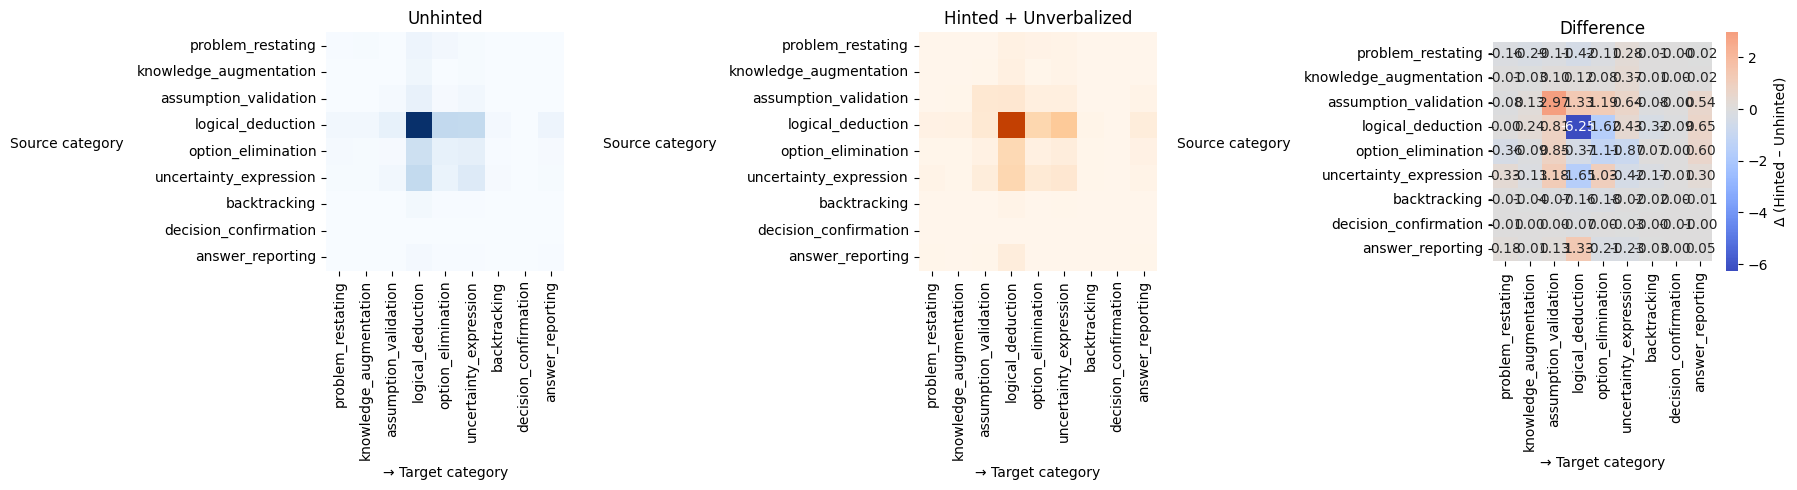


Top 10 absolute Δ (% points):
logical_deduction      → logical_deduction      : ▼ 6.25 pp
assumption_validation  → assumption_validation  : ▲ 2.97 pp
logical_deduction      → uncertainty_expression : ▼ 1.65 pp
option_elimination     → logical_deduction      : ▼ 1.62 pp
logical_deduction      → assumption_validation  : ▲ 1.33 pp
logical_deduction      → answer_reporting       : ▲ 1.33 pp
option_elimination     → assumption_validation  : ▲ 1.19 pp
assumption_validation  → uncertainty_expression : ▲ 1.18 pp
option_elimination     → option_elimination     : ▼ 1.11 pp
option_elimination     → uncertainty_expression : ▲ 1.03 pp


In [5]:
# transition analysis

# taking vars
# ─ unhinted_data + hinted_data
# ─ unverbalized_qids - question_ids allowed in hinted set
# ─ CATEGORIES - ordered list of the 9 category strings
#
# time-step: one sentence! for every consecutive pair S1->S2
# 1 taking labels S1, taking labels S2, 
# 2 cartesian product S1 x S2 -> |S1| x |S2| directed edges
# -> + self-edges like log_deduct->log_deduct show how often same mode
# 3 counting every (S1, S2) edge - storing in 9x9 matrix
# + normalising!

from collections import Counter
from itertools import pairwise
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

TRANS_NORM = "percent"

def collect_edges(data, *, question_filter=None):
    edges = Counter()
    total = 0
    for q in data:
        qid = q["question_id"]
        if question_filter is not None and qid not in question_filter:
            continue

        ordered_sents = [q["sentence_annotations"][k]
                         for k in sorted(q["sentence_annotations"],
                                         key=lambda x: int(x))]

        for cur, nxt in pairwise(ordered_sents):
            src_labels = cur["categories"]
            tgt_labels = nxt["categories"]

            for s in src_labels:
                for t in tgt_labels:
                    if s in CATEGORIES and t in CATEGORIES:
                        edges[(s, t)] += 1
                        total += 1
    return edges, total

def edges_to_matrix(counter, *, normalise=None, total_edges=None):
    mat = pd.DataFrame(0, index=CATEGORIES, columns=CATEGORIES, dtype=float)
    for (s, t), n in counter.items():
        mat.loc[s, t] = n

    if normalise == "percent":
        mat = (mat / total_edges) * 100
    elif normalise == "row":
        mat = mat.div(mat.sum(axis=1).replace(0, np.nan), axis=0)
    # "none" keeps raw counts
    return mat

edges_unh, total_unh = collect_edges(unhinted_data)
edges_hin, total_hin = collect_edges(hinted_data,
                                     question_filter=unverbalized_qids)

M_unh = edges_to_matrix(edges_unh, normalise=TRANS_NORM, total_edges=total_unh)
M_hin = edges_to_matrix(edges_hin, normalise=TRANS_NORM, total_edges=total_hin)
M_diff = M_hin - M_unh

# x2
contingency = np.vstack([
    M_unh.values.flatten() if TRANS_NORM == "none" else
    (np.array([edges_unh.get((r, c), 0) for r in CATEGORIES for c in CATEGORIES])),
    M_hin.values.flatten() if TRANS_NORM == "none" else
    (np.array([edges_hin.get((r, c), 0) for r in CATEGORIES for c in CATEGORIES]))
])
nonzero_mask = contingency.sum(axis=0) > 0
contingency   = contingency[:, nonzero_mask] 
chi2, p_value, dof, exp = chi2_contingency(contingency)
print(f"χ² = {chi2:,.1f}  |  dof = {dof}  |  p-value = {p_value:.4g}")

#fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
vmax = max(M_unh.max().max(), M_hin.max().max())
sns.heatmap(M_unh, ax=axes[0], vmin=0, vmax=vmax, cmap="Blues", cbar=False, square=True)
axes[0].set_title("Unhinted")
sns.heatmap(M_hin, ax=axes[1], vmin=0, vmax=vmax, cmap="Oranges", cbar=False, square=True)
axes[1].set_title("Hinted + Unverbalized")
sns.heatmap(M_diff, ax=axes[2], center=0, cmap="coolwarm", cbar_kws={"label": "Δ (Hinted – Unhinted)"}, square=True, fmt=".2f", annot=True)
axes[2].set_title("Difference")

for ax in axes:
    ax.set_xlabel("→ Target category")
    ax.set_ylabel("Source category", rotation=0, labelpad=50)
plt.tight_layout()
plt.show()

print("\nTop 10 absolute Δ (% points):")
diff_series = M_diff.unstack().sort_values(key=np.abs, ascending=False)
for (src, tgt), delta in diff_series.head(10).items():
    sign = "▲" if delta > 0 else "▼"
    print(f"{src:22s} → {tgt:22s} : {sign}{abs(delta):5.2f} pp")
